In [26]:
# Set up environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import numpy as np

from body_visualizer.tools.vis_tools import render_smpl_params
from body_visualizer.tools.vis_tools import imagearray2file, show_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#This tutorial requires 'vposer_v2_05'

from os import path as osp
vposer_dir = './backbones/human_body_prior'
support_dir = vposer_dir + '/support_data/dowloads'
expr_dir = osp.join(support_dir,'vposer_v2_05') #'TRAINED_MODEL_DIRECTORY'  in this directory the trained model along with the model code exist
bm_fname =  osp.join(support_dir,'models/smplx/SMPLX_NEUTRAL.npz') #'PATH_TO_SMPLX_model.npz'  obtain from https://smpl-x.is.tue.mpg.de/downloads

print(expr_dir)
print(bm_fname)

./backbones/human_body_prior/support_data/dowloads/vposer_v2_05
./backbones/human_body_prior/support_data/dowloads/models/smplx/SMPLX_NEUTRAL.npz


In [7]:
#Loading SMPLx Body Model
from human_body_prior.body_model.body_model import BodyModel

bm = BodyModel(bm_fname=bm_fname).to('cuda')

In [8]:
#Loading VPoser Body Pose Prior
from human_body_prior.tools.model_loader import load_model
from human_body_prior.models.vposer_model import VPoser
vp, ps = load_model(expr_dir, model_code=VPoser,
                              remove_words_in_model_weights='vp_model.',
                              disable_grad=True)
vp = vp.to('cuda')

2023-06-26 16:08:57.434 | INFO     | human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: ./backbones/human_body_prior/support_data/dowloads/vposer_v2_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt


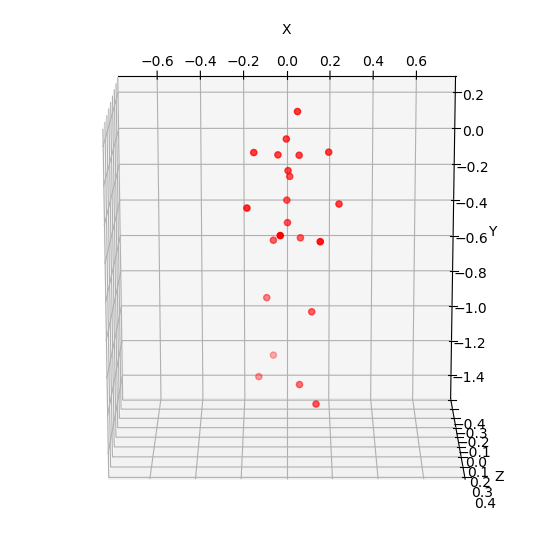

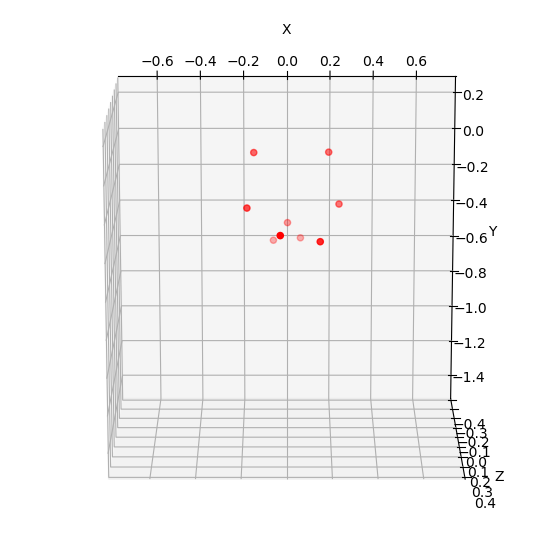

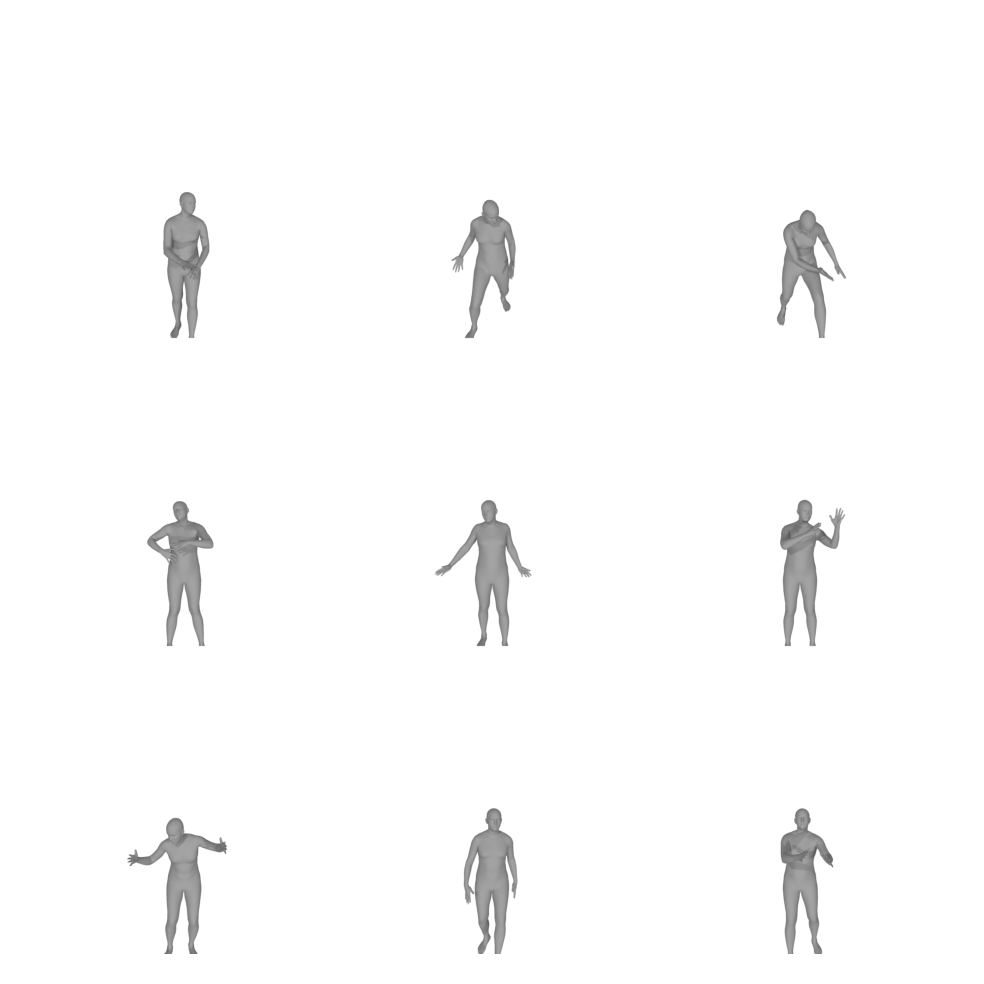

In [73]:
joint_names = {       
            0: 'L_Hip',
            3: 'L_Knee',
            6: 'L_Ankle',
            9: 'L_Foot',
         
            1: 'R_Hip',
            4: 'R_Knee',
            7: 'R_Ankle',
            10: 'R_Foot',
         
            2: 'Spine1',
            5: 'Spine2',
            8: 'Spine3',
            11: 'Neck',
            14: 'Head', # 15?
         
            12: 'L_Collar',
            15: 'L_Shoulder',
            17: 'L_Elbow',
            19: 'L_Wrist',
            13: 'R_Collar',
            16: 'R_Shoulder',
            18: 'R_Elbow',
            20: 'R_Wrist',
        }

num_poses = 9 # number of body poses in each batch

sampled_pose_body = vp.sample_poses(num_poses=num_poses)['pose_body'].contiguous() # will a generate Nx1x21x3 tensor of body poses 

# plot the sampled poses
plot_pose_body = {'pose_body':sampled_pose_body.view(num_poses, -1)}
body = bm(**plot_pose_body)
plot_pose_full = body.Jtr[0]    # only first sample

plot_pose = plot_pose_full.cpu().numpy()[:22]   # exclude hand joints

# Full body
fig = plt.figure(figsize=(7,7),)
ax = fig.add_subplot(projection='3d')
ax.scatter(plot_pose[:,0], plot_pose[:,1], plot_pose[:,2], c='r', marker='o')

ax.view_init(elev=105., azim=-90)
ax.set_xlabel('X')
ax.set_xlim(-0.75, 0.75)
ax.set_ylabel('Y')
ax.set_ylim(-1.5, 0.25)
ax.set_zlabel('Z')
ax.set_zlim(-0.4, 0.4)
plt.show()

# Subset for lifting
idxs = [
        0, # Pelvis
        2,  # LL
        1,  # RL

        # 1,4,7,
        # 2,11,14,

        17,19,21,   # RA
        16,18,20    # LA
        ]
plot_pose = plot_pose_full.cpu().numpy()[:22][idxs]
fig = plt.figure(figsize=(7,7),)
ax = fig.add_subplot(projection='3d')
ax.scatter(plot_pose[:,0], plot_pose[:,1], plot_pose[:,2], c='r', marker='o')

ax.view_init(elev=105., azim=-90)
ax.set_xlabel('X')
ax.set_xlim(-0.75, 0.75)
ax.set_ylabel('Y')
ax.set_ylim(-1.5, 0.25)
ax.set_zlabel('Z')
ax.set_zlim(-0.4, 0.4)
plt.show()

sampled_pose_body = sampled_pose_body.view(num_poses, -1)
images = render_smpl_params(bm, {'pose_body':sampled_pose_body}).reshape(3,3,1,800,800,3)
img = imagearray2file(images)
show_image(np.array(img[0]))

# Pose Lifter

In [46]:
from backbones.auto_UPDRS.models import body_pose

def fix_model_setup(in_ckpt_path, out_dict_path):
    '''
    Helper to fix the model setup
    '''
    # load the pretrained model in Mohsens setup
    model = body_pose.Lifter()    # CHANGE THIS AS NECESSARY
    dict = torch.load(in_ckpt_path).state_dict()
    model.load_state_dict(dict)
    # Fix the setup by only saving the state_dict
    torch.save(model.state_dict(), out_dict_path)
    print("Saved new", out_dict_path)

# fix the setup
in_ckpt_path = './backbones/auto_UPDRS/model_checkpoints/body_pose/mohsen_models/model_pretrain.pt'
out_dict_path = './backbones/auto_UPDRS/model_checkpoints/body_pose/mvp_3D_h36m.pth'

fix_model_setup(in_ckpt_path, out_dict_path)

Saved new ./backbones/auto_UPDRS/model_checkpoints/body_pose/mvp_3D_h36m.pth


In [48]:
from backbones.auto_UPDRS.models import body_pose

lifter_ckpt_path = './backbones/auto_UPDRS/model_checkpoints/body_pose/mvp_3D_h36m.pth'

lifter = body_pose.Lifter()
lifter.load_state_dict(torch.load(lifter_ckpt_path))
lifter.eval()


with torch.no_grad():
    confs_2d = np.ones((1, 14))

    pose_2d = plot_pose[]

Lifter(
  (upscale): Linear(in_features=45, out_features=1024, bias=True)
  (res_common): res_block(
    (l1): Linear(in_features=1024, out_features=1024, bias=True)
    (l2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (res_pose1): res_block(
    (l1): Linear(in_features=1024, out_features=1024, bias=True)
    (l2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (res_pose2): res_block(
    (l1): Linear(in_features=1024, out_features=1024, bias=True)
    (l2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (res_cam1): res_block(
    (l1): Linear(in_features=1024, out_features=1024, bias=True)
    (l2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (res_cam2): res_block(
    (l1): Linear(in_features=1024, out_features=1024, bias=True)
    (l2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (pose3d): Linear(in_features=1024, out_features=45, bias=True)
  (enc_rot): Linear(in_features=1024, out_features=3, bias=Tru